# Comparativa de resultados
A lo largo de este notebook se cubre la quinta fase de la metodología CRIPS-DM, en este caso la evaluación de los resultados

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :


3. **Preparación de los Datos (Data Preparation)** 
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. **Modelado (Modeling)**  
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico.

5. <span style="color:#66FF99;">**Evaluación (Evaluation)**  </span> 
   - Evaluación de los resultados obtenidos y comparativa de los mismos emtre modelos.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.


## Evaluación 


Tras el entrenamiento de diversos modelos 

Esta sección puede ser dividida en dos subsecciones:

1) Evaluación y comparativa cuantitativa: se comapran resultados entre modelos de acuerdo con funciones de rendimiento

2) Evaluación cualitativa: se estudia como se comporta cada uno de los modelos ante las imágenes, y su relación con los etiquetados del dataset

### 1.0 Requisitos previos

Previo a la obtención de métricas y la obtención de comparativas visuales, es necesario definir los métodos de inferencia de cada uno de los modelos a comparar. Para ello se define una función para cada uno de ellos y un método que dado el modelo llama al método que genera la inferencia del mismo

En primera instancia, se cargan todas las librerias necesarias para cada uno de ellos:

In [159]:
import numpy as np
import pandas as pd
import torch
import os
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from utils import  load_yaml_file
from pycocotools.coco import COCO
from typing import Literal
from skimage.transform import resize
from tqdm import tqdm
import time
from IPython.display import clear_output
from pathlib import Path
from utils import  load_yaml_file, download_zip
from transformers import CLIPProcessor, CLIPModel
import cv2
from pycocotools.coco import COCO
import random
from utils import  load_yaml_file, download_zip
from clip import load, tokenize
import torchvision.transforms as transforms
from PIL import Image
import clip
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
from torchvision.models.detection import retinanet_resnet50_fpn
import torchvision.transforms as T
from tensorflow import keras
import seaborn as sns



En segundo lugar, se cargan los datos relativos al dataset y algunos diccionarios con los preprocesamientos de nombres de clases y mapeos de índices a `clase_id` del dataset de coco

In [160]:
yaml = load_yaml_file()
objetives = yaml["objetive_classes"]

In [161]:
DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.join(os.getcwd(),"..", DIR_TRAIN_IMGS)

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=59.74s)
creating index...
index created!


In [162]:
categories = coco.loadCats(coco.getCatIds())
category_info_id = {cat['id']: cat['name'] for cat in categories}
category_info_name = { cat['name']:cat['id'] for cat in categories}

id_objetives = [category_info_name[name] for name in objetives]
category_info_objetive = {i:category_info_id[i] for i in id_objetives}
category_info_objetive[0] = "background"
categories_names_by_index = { i: category_info_objetive[id_cat] for i , id_cat in enumerate(sorted(category_info_objetive.keys()))}


dict_class_index = {key:i for i , key in enumerate(sorted(category_info_objetive.keys()))}
mapper_indexModel_index_result = {value:i for i, value in enumerate(sorted(category_info_objetive.keys()))}

In [163]:
img_ids = set(coco.getImgIds(catIds=id_objetives[0]))

for cat in id_objetives[1:]:
    img_ids |= set(coco.getImgIds(catIds=cat))

img_ids = list(img_ids)

In [164]:
def get_data_id_image(id_image, coco):

    img_info = coco.loadImgs(id_image)[0]
    height, width = img_info['height'], img_info['width']
    img_path = f"{DIR_TRAIN_IMGS}/{img_info['file_name']}"

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=id_image)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        category_id = ann['category_id']

        if(category_id in category_info_objetive.keys()):
            binary_mask = coco.annToMask(ann)
            mask[binary_mask == 1] = category_id
    image = cv2.resize(image,(256, 256))
    mask = cv2.resize(mask,(256, 256), interpolation=cv2.INTER_NEAREST) 
    mask = np.vectorize(lambda x: dict_class_index.get(x, x))(mask)

    # print("unique", np.unique(mask), dict_class_index)
    mask = np.eye(11)[mask].transpose(2,0,1)

    return image, mask

In [165]:
def preprocess_dataset_mask(mask,mapper_indexModel_index_result, categories_names_by_index):

    mask_proprocessed = np.vectorize(lambda x: mapper_indexModel_index_result.get(x, x))(mask)
    one_hot_scores = np.zeros((len(categories_names_by_index), mask.shape[0], mask.shape[1]))

    for clase in sorted(categories_names_by_index.keys()):

        one_hot_scores[clase, :, :] = np.where(mask_proprocessed == clase,1 , 0)

    one_hot_scores[0, :, :] = 1 - one_hot_scores[1:, :, :].sum(axis=0)

    return one_hot_scores
    


In [166]:
def plot_image_and_mask(image,mask,categories_names_by_index: dict):
    class_ids = sorted([cid for cid in np.unique(mask)])
    colors = plt.cm.get_cmap('tab10',len(categories_names_by_index))  

    fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].imshow(image)
    ax[0].set_title("Imagen")
    ax[0].axis("off")
    mask_colored = np.zeros((mask.shape[0],mask.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_colored[mask==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    # print(mask_colored)
    ax[1].imshow(mask_colored)
    ax[1].set_title("Máscara")
    ax[1].axis("off")

    patches = [mpatches.Patch(color=colors(i), label=categories_names_by_index[cid])
               for i, cid in enumerate(class_ids)]
    ax[1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    return

Se declaran e importan los modelos, tanto los preentrenados como las redes entrenadas desde cero:

In [167]:

CONS_TRHESHOLD = 0.5
unet_baseline= r"C:\Users\ruben\Desktop\code_tfm\models\trained_models\baseline_UNET_final.keras"
model_unet_baseline = load_model(unet_baseline, compile=False)

shape_unet_baseline = (256, 256)

In [168]:
yolo_model = YOLO("yolov8s.pt") 

In [169]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device='cpu')

In [170]:
sam_checkpoint = r"C:\Users\ruben\Desktop\code_tfm\models\SAM\sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device= "cpu" )

sam_model = SamPredictor(sam)


sam_model_segment_everything = SamAutomaticMaskGenerator(sam)

In [171]:
retina_model = retinanet_resnet50_fpn(pretrained=True)
retina_model.eval()  


c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ruben\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [172]:
path_unet_final_pipeline = r"C:\Users\ruben\Desktop\code_tfm\models\trained_models\final_ensemble_second_block.keras"
model_final_pipeline_unet = keras.models.load_model(path_unet_final_pipeline, compile=False)


### 1.1 Inferencia de U-Net Baseline

In [173]:
def process_inference_base_unet(img,unet_model_baseline):

    target_size = (256, 256)
    img_resized = cv2.resize(img, target_size) 
    img_resized = img_resized.astype(np.float32)/255.0
    input_tensor = np.expand_dims(img_resized,axis=0)  
    prediction = unet_model_baseline.predict(input_tensor)  

    pred_mask = np.argmax(prediction[0],axis=-1) 
    prediction  = prediction[0]

    return pred_mask,prediction 



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


C:\Users\ruben\AppData\Local\Temp\ipykernel_30052\2286204260.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10',len(categories_names_by_index))


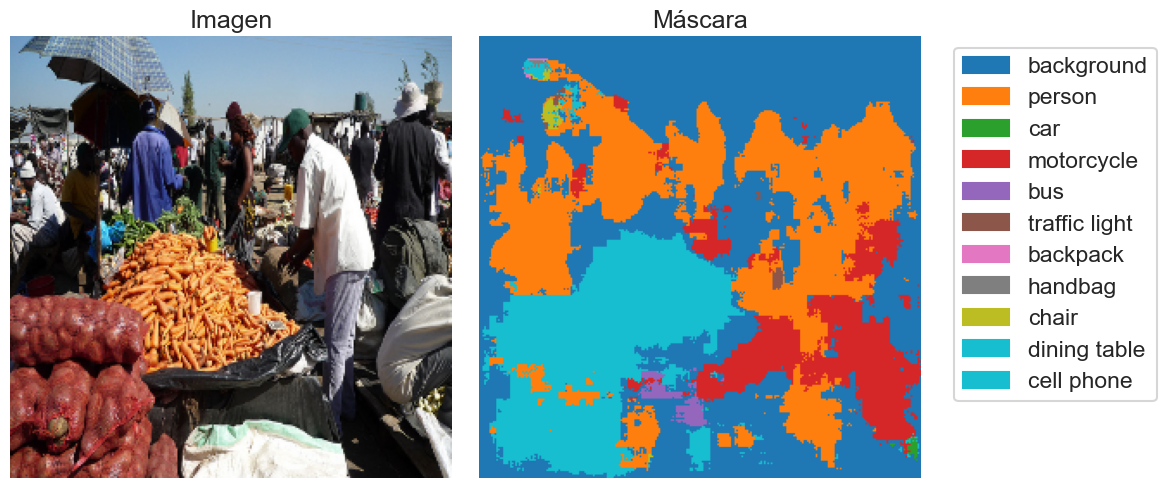

In [174]:
img,mask = get_data_id_image(img_ids[0], coco)
pred_mask, probs = process_inference_base_unet(img, model_unet_baseline)

plot_image_and_mask(img,pred_mask,categories_names_by_index)

### 1.2 Inferencia de YOLOv8+SAM

In [175]:

def yolov8_inference(image, yolo_model):

    yolo_boxes = []
    yolo_prob = []
    yolo_label = []

    results = yolo_model(image)

    for box_info in results[0]:
        x1,y1,x2,y2, conf, label = box_info.boxes.data[0].tolist()

        # Dado que yolo detecta más clases que nuestro conjunto de objetivos presente, filtramos las bounding boxes encontradas
        if (label+1) in id_objetives:
            #x1,y1,x2,y2=map(int,box.xyxy[0])
            yolo_boxes.append( (x1,y1,x2,y2))
            yolo_prob.append(conf)
            yolo_label.append(label + 1)

    return yolo_boxes,yolo_prob,yolo_label


def sam_segmentation_object_detection_yolo(image,yolo_boxes, yolo_probs, yolo_labels,sam_model, dict_class_index ):
    sam_model.set_image(image)

    final_mask = np.zeros(image.shape[:2],dtype=np.uint8)
    current_scores = np.zeros(image.shape[:2],dtype=np.uint8)

    for box, score, label in zip(yolo_boxes,yolo_probs, yolo_labels):
        if(score>CONS_TRHESHOLD and label in category_info_objetive.keys()):
            masks,scores,logits =sam_model.predict(point_coords=None,point_labels=None,box= np.array([round(x) for x in box]),
                multimask_output=False
            )

            if np.any(masks):
                mask_values=np.where(masks[0],scores,0)
                final_mask=np.where(mask_values>current_scores,label,final_mask)
                current_scores=np.maximum(mask_values, current_scores)


    lookup=np.vectorize(lambda k: dict_class_index[k])
    mask_by_index=lookup(final_mask)
    return mask_by_index, current_scores



def process_inference_yolo_sam(image,yolo_model,sam_model,dict_class_index ):

    yolo_boxes, yolo_prob, yolo_label = yolov8_inference(image,yolo_model)

    mask, score = sam_segmentation_object_detection_yolo(image,yolo_boxes, yolo_prob, yolo_label, sam_model, dict_class_index )

    score = np.where(mask == 0, 1, score)

    score_preprocessed  = np.zeros((score.shape[0], score.shape[1], len(dict_class_index.keys())))

    for _, val in dict_class_index.items():
        score_preprocessed[:,:,val] = np.where(mask == val, score, 0 )

    score_preprocessed[:,:,0] = 1-np.sum(score_preprocessed[:,:,1:],axis=-1)

    return mask,  score_preprocessed




In [176]:
image, mask_gt = get_data_id_image(img_ids[108], coco)

result,  scores2  = process_inference_yolo_sam(image,yolo_model,sam_model,dict_class_index )


0: 640x640 1 person, 1 surfboard, 533.8ms
Speed: 22.6ms preprocess, 533.8ms inference, 23.2ms postprocess per image at shape (1, 3, 640, 640)


### 1.3 Inferencia de RetinaNet+SAM

In [177]:
def retina_inference(image, retina_model):
    
    transform = T.Compose([
        T.ToTensor()
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = retina_model(img_tensor)

    boxes=outputs[0]['boxes']
    scores=outputs[0]['scores']
    labels=outputs[0]['labels']

    return boxes,scores,labels



def sam_segmentation_object_detection_retina(image,retina_boxes, retina_prob, retina_label,sam_model, dict_class_index ):
    sam_model.set_image(image)

    final_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    current_scores = np.zeros(image.shape[:2], dtype=np.uint8)

    # print("having label ", retina_label, len(retina_label))
    # print("having retina_prob ", len(retina_prob))
    # print("having label ", len(retina_boxes))

    for box, score, label in zip(retina_boxes, retina_prob, retina_label):
        #print("score is ",score.item(), " against ", CONS_TRHESHOLD, "label is ", label.item())
        if(score.item() > CONS_TRHESHOLD and label.item() in category_info_objetive.keys()):
            masks, scores, logits = sam_model.predict(
                point_coords=None,
                point_labels=None,
                box= np.array(box.tolist())[None, :] ,
                multimask_output=False
            )

            if np.any(masks):

                mask_values=np.where(masks[0],  scores, 0)
                final_mask=np.where(mask_values>current_scores , label.item(), final_mask)
                current_scores=np.maximum(mask_values,current_scores)


    lookup=np.vectorize(lambda k: dict_class_index[k])
    mask_by_index=lookup(final_mask)

    return mask_by_index,current_scores



def process_inference_retina_sam(image,retina_model,sam_model,dict_class_index ):

    retina_boxes, retina_prob, retina_label = retina_inference(image,retina_model)

    mask, score = sam_segmentation_object_detection_retina(image,retina_boxes, retina_prob, retina_label, sam_model, dict_class_index )

    score = np.where(mask == 0, 1, score)

    score_preprocessed  = np.zeros((score.shape[0], score.shape[1], len(dict_class_index.keys())))

    for _, val in dict_class_index.items():
        score_preprocessed[:,:,val] = np.where(mask == val, score, 0 )

    score_preprocessed[:,:,0] = 1-np.sum(score_preprocessed[:,:,1:],axis=-1)

    return mask,  score_preprocessed

In [178]:
image, mask_gt = get_data_id_image(img_ids[0], coco)

result, scores  = process_inference_retina_sam(image,retina_model,sam_model,dict_class_index )

### 1.4 Inferencia de CLIP+SAM

In [179]:
TEXT_PROMPTS = ["a photo of a " + obj + " surrounded by dark" for obj in yaml["objetive_classes"]] +  ["a photo of a something surrounded by dark" , "a photo of a background surrounded by dark", "A clear blue sky above the horizon, with silhouettes of buildings and people below"]



def prepare_clip_input_from_mask(img, mask, clip_proprocess ):
    coords = np.argwhere(mask)
    if coords.size == 0:
        return None
    y0,x0=coords.min(axis=0)
    y1,x1=coords.max(axis=0)+1
    cropped_img=img[y0:y1,x0:x1]
    cropped_mask=mask[y0:y1,x0:x1]

    cropped_img=np.copy(cropped_img)
    cropped_img[~cropped_mask]=0
    pil_image=Image.fromarray(cropped_img)
    clip_input=clip_proprocess(pil_image).unsqueeze(0).to("cpu")
    return clip_input,pil_image



def inference_sam_clip(image, clip_model,clip_preprocess,sam_model,text_prompts = TEXT_PROMPTS):

    result_sam=sam_model.generate(image)
    result=np.zeros((image.shape[0], image.shape[1]))

    text_tokens=clip.tokenize(text_prompts).to('cpu')


    for i, mask_dict in enumerate(result_sam):
        mask = mask_dict["segmentation"]  
        clip_input, cropped_pil = prepare_clip_input_from_mask(image, mask, clip_proprocess = clip_preprocess)

        if clip_input is None:
            continue
        with torch.no_grad():
            image_features = clip_model.encode_image(clip_input)
            text_features = clip_model.encode_text(text_tokens)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = (image_features @ text_features.T).squeeze(0)
            best_idx = similarity.argmax().item()

            if(best_idx<10):
                result[mask] = best_idx + 1

    return result


def preprocess_model_output(mask):
    mask=mask.astype(int)
    one_hot = np.eye(11)[mask]
    one_hot = one_hot.transpose(2,0,1)
    return one_hot


def process_inference_sam_clip(image,clip_model,clip_preprocess,sam_model_segment_everything,text_prompts = TEXT_PROMPTS ):

        
        result = inference_sam_clip(image,clip_model,clip_preprocess,sam_model_segment_everything,text_prompts = text_prompts)
        proprocessed_mask = preprocess_model_output(result)
        proprocessed_mask = np.transpose(proprocessed_mask,(1,2,0))
        return result,proprocessed_mask






In [180]:
image, mask_gt = get_data_id_image(img_ids[0], coco)
result, proprocessed_mask  = process_inference_sam_clip(image,clip_model,clip_preprocess,sam_model_segment_everything,text_prompts = TEXT_PROMPTS )

### 1.5 Inferencia del modelo final (Retinanet + SAM + U-Net)

In [181]:
def process_inference_corrector_block(image,result_prev_block,unet_final_model):
    target_size = (256, 256)
    img_resized=cv2.resize(image, target_size) 
    img_resized=img_resized.astype(np.float32)/255.0
  

    pipeline_output=  result_prev_block.astype(np.uint8)
    pipeline_output= cv2.resize(pipeline_output, target_size)
    pipeline_output= tf.expand_dims(pipeline_output, axis=-1) 
    #pipeline_output  = pipeline_output.tobytes()
    final_input = tf.concat([img_resized,tf.cast(pipeline_output, tf.float32)], axis=-1)

    input_tensor=np.expand_dims(final_input,axis=0)
    prediction=unet_final_model.predict(input_tensor)  
    pred_mask=np.argmax(prediction[0],axis=-1) 
    prediction  =prediction[0]


    return pred_mask,prediction 


def process_inference_segmentator_block(image,yolo_model,sam_model,dict_class_index):
    yolo_boxes, yolo_prob, yolo_label = yolov8_inference(image,yolo_model)
    mask, score = sam_segmentation_object_detection_yolo(image,yolo_boxes, yolo_prob, yolo_label, sam_model, dict_class_index )

    return mask, score


def process_inference_full_pipeline(image,unet_final_model,yolo_model,sam_model, dict_class_index = dict_class_index ):

        
        result, _  = process_inference_segmentator_block(image,yolo_model,sam_model,dict_class_index)
        pred_mask,prediction = process_inference_corrector_block(image,result,unet_final_model)

        return pred_mask,prediction

In [182]:
pred_mask,probs = process_inference_full_pipeline(image,model_final_pipeline_unet,yolo_model,sam_model, dict_class_index = dict_class_index )


0: 640x640 7 persons, 1 backpack, 3 umbrellas, 1 cup, 510.5ms
Speed: 12.7ms preprocess, 510.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


### 1.6 Función universal

A continuación, se implementa una función que carga todos los modelos a la vez, y según el parámetro del tipo de modelo a aplicar, aplica el mismo. Esto permite reducir en gran medida la alta complejidad a nivel de paso de parámetros que resultaría de hacerse con otro procedimiento.

In [183]:

def inference_model_pipeline(image,
                             type_model = Literal["unet_base", "sam_clip", "yolo_sam", "retinanet_sam", "final_model"] ,
                             **kwargs):
    
    if(type_model == "unet_base" ):
        model_unet_baseline = kwargs.get("model_unet_baseline", None)
        pred_mask, probs = process_inference_base_unet(image, model_unet_baseline)

    elif(type_model == "sam_clip"):
         clip_model = kwargs.get("clip_model", None)
         clip_preprocess = kwargs.get("clip_preprocess", None)
         sam_model_segment_everything = kwargs.get("sam_model_segment_everything", None)
         pred_mask, probs = process_inference_sam_clip(image,clip_model,clip_preprocess,sam_model_segment_everything )
    
    elif(type_model == "yolo_sam" ):
        yolo_model = kwargs.get("yolo_model", None)
        sam_model = kwargs.get("sam_model", None)
        dict_class_index = kwargs.get("dict_class_index", None)
        pred_mask, probs = process_inference_yolo_sam(image,yolo_model,sam_model,dict_class_index )

    elif(type_model == "retinanet_sam" ):
        retina_model = kwargs.get("retina_model", None)
        sam_model = kwargs.get("sam_model", None)
        dict_class_index = kwargs.get("dict_class_index", None)
        pred_mask, probs =  process_inference_retina_sam(image,retina_model,sam_model,dict_class_index )  

    elif(type_model == "final_model" ):
        model_final_pipeline_unet = kwargs.get("model_final_pipeline_unet", None)
        yolo_model = kwargs.get("yolo_model", None)
        sam_model = kwargs.get("sam_model", None)
        dict_class_index = kwargs.get("dict_class_index", None)
        pred_mask, probs = process_inference_full_pipeline(image,model_final_pipeline_unet,yolo_model,sam_model, dict_class_index = dict_class_index )

    else:
        return None
    

    return pred_mask, probs 

In [184]:
models_supported = ["unet_base", "sam_clip", "yolo_sam", "retinanet_sam", "final_model"]

In [185]:
additional_params = {
    "model_unet_baseline": model_unet_baseline,
    "clip_model": clip_model,
    "clip_preprocess":clip_preprocess,
    "sam_model_segment_everything": sam_model_segment_everything, 
    "yolo_model": yolo_model,
    "sam_model": sam_model,
    "dict_class_index": dict_class_index,
    "retina_model": retina_model,
    "model_final_pipeline_unet": model_final_pipeline_unet
}


## 1. Evaluación cuantitativa

En este caso, se ha considerado relevante el estudio de tres métricas de rendimeinto para evaluar el funcionamiento de cada uno de los modelos entrenados

1) Pixel accuracy
2) IoU media
3) Mean average precission

In [115]:

def compute_iou(pred_mask, true_mask) -> float:


    ious=[]
    num_classes=pred_mask.shape[0]

    for c in range(num_classes):
        pred=pred_mask[c]
        truth=true_mask[c]

        if  truth.any():

            intersection=np.logical_and(pred,truth).sum()
            union=np.logical_or(pred,truth).sum()

            iou=intersection/union if union != 0 else 0.0
            ious.append(iou)

            # print("For class ", c, " has value ", iou)



    return np.mean(ious)


def mean_pixel_accuracy(pred_mask, true_mask) -> float:

    # print("Shape is ", pred_mask.shape)
    # print("Shape2 is ", true_mask.shape)
    class_accuracies=[]

    for c in range(pred_mask.shape[0]):
        pred=pred_mask[c]
        truth=true_mask[c]

        total_true=truth.sum()
        if total_true!=0:

            correct=np.logical_and(pred, truth).sum()
            acc = correct/total_true
            class_accuracies.append(acc)
            
            # print("For class ", c, " has value ", acc)

    return np.mean(class_accuracies)



def mean_average_precision(prob_mask, true_mask) -> float:

    C,H,W= true_mask.shape
    aps=[]

    for c in range(C):
        y_true=true_mask[c].ravel().astype(int)
        y_score=prob_mask[c].ravel()

        if y_true.sum() != 0:
            ap=average_precision_score(y_true, y_score)
            aps.append(ap)

            # print("for ", c, " has value ",ap)


    return np.mean(aps)

In [116]:
def get_value_metrics(prob_mask, ground_truth) -> tuple[float, float, float ]:

    # print("prob mask is ", prob_mask.shape)
    if(len(prob_mask.shape) == 2):
        prob_mask =prob_mask.astype(int)
        prob_mask =np.eye(11)[prob_mask].transpose(2,0,1)

    # print("unique", np.unique(mask), dict_class_index)
        
    # result = mean_pixel_accuracy(mask_one_hot_pred, mask_one_hot_gt)
    mean_pixel_acc = mean_pixel_accuracy(prob_mask, ground_truth)

    # result = compute_iou(mask_one_hot_pred, mask_one_hot_gt)

    iou = compute_iou(prob_mask, ground_truth)

    # mean_average_precision(one_hot_scores[0],mask_one_hot_gt )
    mean_av_pre = mean_average_precision(prob_mask, ground_truth)
    
    return mean_pixel_acc, iou, mean_av_pre


In [118]:
results_acc = {model : [] for model in ["unet_base", "sam_clip", "yolo_sam", "retinanet_sam", "final_model"]}
results_iou = {model : [] for model in ["unet_base", "sam_clip", "yolo_sam", "retinanet_sam", "final_model"]}
results_map = {model : [] for model in ["unet_base", "sam_clip", "yolo_sam", "retinanet_sam", "final_model"]}
results_tiempo = {model : [] for model in ["unet_base", "sam_clip", "yolo_sam", "retinanet_sam", "final_model"]}


N = 50

random_indices = [random.randint(0,len(img_ids)-1) for _ in range(N)]
for i in tqdm(random_indices,desc="Porcesando imágenes para la obtención de las métricas"):

    if(i%10 == 0 ):
        clear_output(wait=True)

    for j, model in enumerate(["unet_base", "sam_clip", "yolo_sam", "retinanet_sam", "final_model"]):

        image,mask_gt = get_data_id_image(img_ids[i], coco)
        t1 = time.time()
        pred_mask,probs =  inference_model_pipeline(image, type_model=model,**additional_params)
        t2= time.time()
        t_tot = t2-t1
        # if(True):
        #     a
        # print("model", model, "shape ",probs.shape,  mask_gt.shape)

        mean_pixel_acc, iou, mean_av_pre = get_value_metrics(pred_mask, mask_gt)
        # print(f"Value metrics for model {model}, {mean_pixel_acc=} , {iou=}, {mean_av_pre=}")

        results_acc[model].append(mean_pixel_acc)
        results_iou[model].append(iou)
        results_map[model].append(mean_av_pre)
        results_tiempo[model].append(t_tot)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step



0: 640x640 2 persons, 2 bottles, 1 cup, 1 cell phone, 452.2ms
Speed: 12.3ms preprocess, 452.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 2 bottles, 1 cup, 1 cell phone, 427.4ms
Speed: 10.2ms preprocess, 427.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Porcesando imágenes para la obtención de las métricas:  94%|█████████▍| 47/50 [3:49:21<13:21, 267.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step



0: 640x640 2 persons, 4 cars, 1 bus, 1 umbrella, 475.8ms
Speed: 15.1ms preprocess, 475.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 4 cars, 1 bus, 1 umbrella, 431.9ms
Speed: 9.1ms preprocess, 431.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Porcesando imágenes para la obtención de las métricas:  96%|█████████▌| 48/50 [3:54:20<09:12, 276.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step



0: 640x640 7 persons, 1 frisbee, 444.2ms
Speed: 10.5ms preprocess, 444.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 persons, 1 frisbee, 418.9ms
Speed: 14.2ms preprocess, 418.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Porcesando imágenes para la obtención de las métricas:  98%|█████████▊| 49/50 [3:59:25<04:45, 285.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step



0: 640x640 1 person, 2 bowls, 1 dining table, 453.8ms
Speed: 14.9ms preprocess, 453.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 2 bowls, 1 dining table, 417.2ms
Speed: 6.2ms preprocess, 417.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Porcesando imágenes para la obtención de las métricas: 100%|██████████| 50/50 [4:03:59<00:00, 292.78s/it]


Se representan de forma gráfica los resultados:

In [120]:

def obtener_dataframe_plot(results_dict,metric_name):
    rows = []
    for model,values in results_dict.items():
        for v in values:
            rows.append({"Modelo": model,"Valor": v,"Metrica":metric_name})
    return pd.DataFrame(rows)
df_acc = obtener_dataframe_plot(results_acc, "Pixel Accuracy")
df_iou = obtener_dataframe_plot(results_iou, "Mean IoU")
df_map = obtener_dataframe_plot(results_map, "mAP")
df_tiempos = obtener_dataframe_plot(results_tiempo, "Tiempo Inferencia")


df_all = pd.concat([df_acc, df_iou,df_map,df_tiempos], ignore_index=True)

path = r"C:\Users\ruben\Desktop\code_tfm\src\logs\train\resultados_finales.xlsx"
df_all.to_excel(path, index=False)

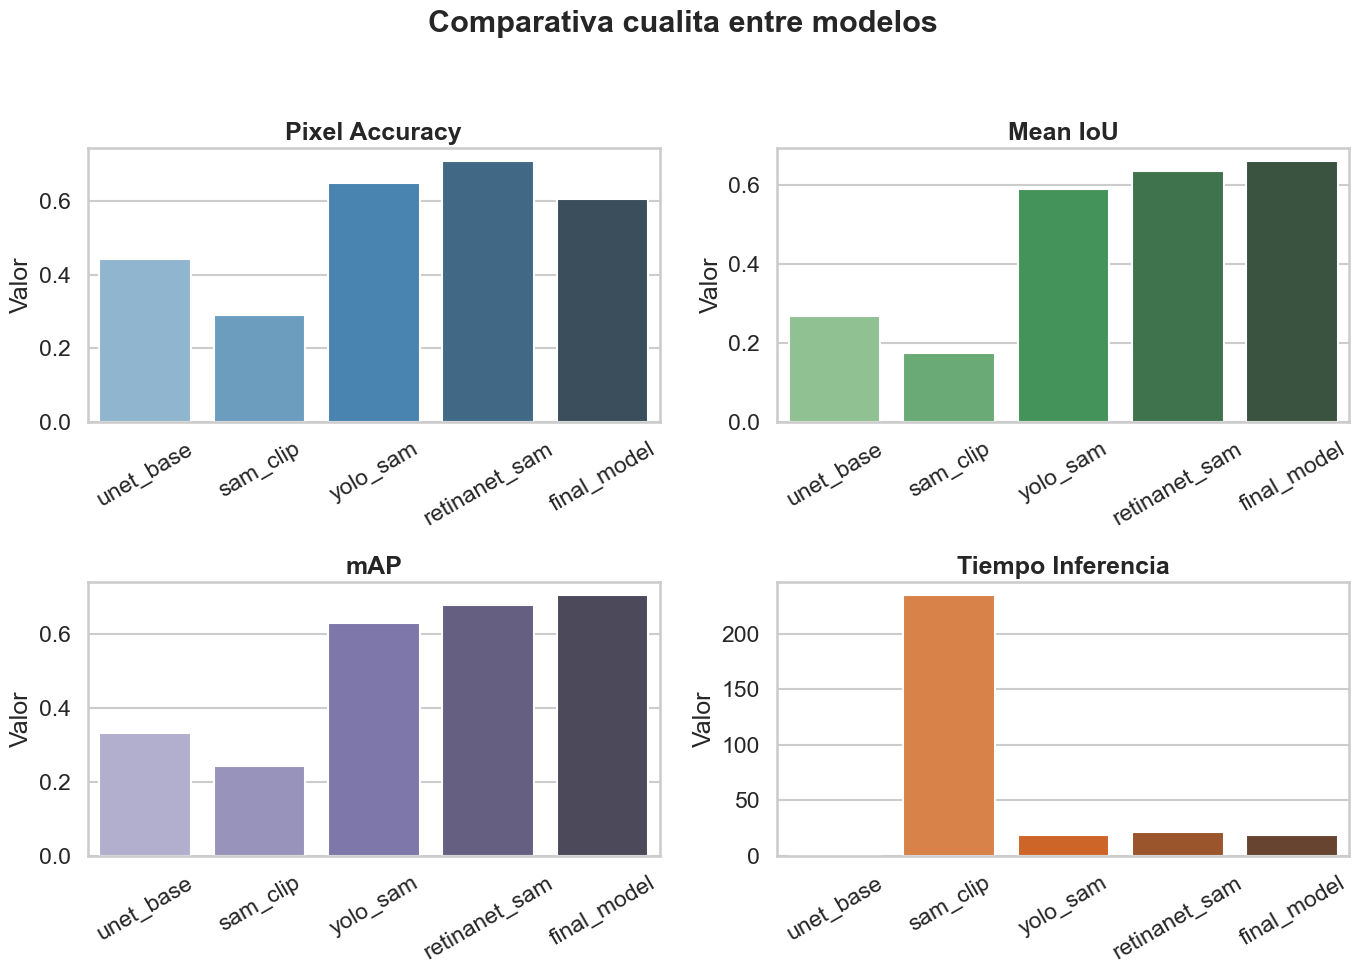

In [157]:
sns.set_theme(style="whitegrid", context="talk")

fig,axes = plt.subplots(2, 2,figsize=(14, 10),sharey=False)
axes = axes.flatten()
metricas=["Pixel Accuracy", "Mean IoU", "mAP", "Tiempo Inferencia"]
colores=["Blues_d", "Greens_d", "Purples_d","Oranges_d"] # Usamos los de la doc por defecto en este caso
for ax, metrica, color in zip(axes, metricas, colores):
    sns.barplot(data=df_all[df_all["Metrica"] == metrica],x="Modelo",y="Valor",hue="Modelo",palette=color,errorbar=None,dodge=False,legend=False,ax=ax)
    ax.set_title(metrica,fontsize=18,weight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Valor")
    ax.tick_params(axis="x",rotation=30)

plt.suptitle("Comparativa cualita entre modelos", fontsize=22, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 2. Evaluación cualitativa

A continuación, se genera la inferencia para cada imagen del dataset y se comprueban no únicamente los resultados del modelo, sino que también su relación con la máscara estipulada por el conjunto de datos seleccionado.
Para ello, hacemos uso de cada una de las pipelines definidas para cada modelo.

#### Plotting de los resultados
Se genera una función para generar un plot que permita comparar resultados de la inferencia de los diferentes modelos y el ground truth


In [186]:
def plot_image_and_mask_and_gt(image,gt, masks:list, model_names:list):
    class_id_to_name = {i:category_info_objetive[key] for i, key in enumerate(sorted(category_info_objetive.keys()))}
    class_predictions = np.unique(np.concatenate([np.unique(mask) for mask in masks + [gt]])).tolist()
    class_ids = sorted(class_predictions)
    class_ids = [elem for elem in sorted(list(class_predictions))]
    colors = plt.cm.get_cmap('tab10',len(class_id_to_name))

    target_shape = (image.shape[0], image.shape[1], 3)
    fig, ax = plt.subplots(1, 2 + len(masks), figsize=(20, 20))
    ax[0].imshow(image)
    ax[0].set_title("Imagen")
    ax[0].axis("off")

    for i, mask_preprocessed in enumerate(masks):
        mask_colored = np.zeros((mask_preprocessed.shape[0],mask_preprocessed.shape[1],3),dtype=np.uint8)
        for j,cid in enumerate(class_ids):
            mask_colored[mask_preprocessed==cid] = (np.array(colors(j)[:3])*255).astype(np.uint8)

        # print(mask_colored)
        #resized_mask = resize(mask_colored, target_shape, preserve_range=True, anti_aliasing=True)
        resized_mask = (resize(mask_colored, target_shape, preserve_range=True, anti_aliasing=True)).astype(np.uint8)

        #reshaped_mask = mask_preprocessed.reshape(target_shape)
        ax[i+1].imshow(resized_mask)
        ax[i+1].set_title(f"Inferencia {model_names[i]}")
        ax[i+1].axis("off")



    mask_gt_colored = np.zeros((gt.shape[0],gt.shape[1],3),dtype=np.uint8)
    for i,cid in enumerate(class_ids):
        mask_gt_colored[gt==cid] = (np.array(colors(i)[:3])*255).astype(np.uint8)

    ax[len(masks)+1].imshow(mask_gt_colored)
    ax[len(masks)+1].set_title("Ground truth")
    ax[len(masks)+1].axis("off")
    patches = [mpatches.Patch(color=colors(i), label=class_id_to_name[cid])
               for i, cid in enumerate(class_ids)]
    ax[len(masks)+1].legend(handles=patches, bbox_to_anchor=(1.05,1),loc='upper left')

    plt.tight_layout()
    plt.show()


C:\Users\ruben\AppData\Local\Temp\ipykernel_22756\1577048514.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10',len(class_id_to_name))


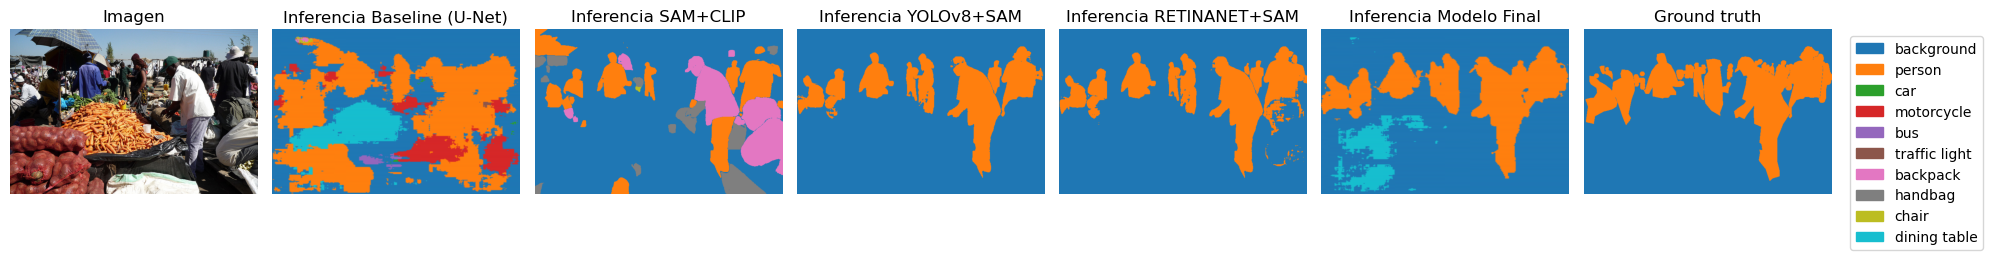

In [ ]:
models_supported = ["Baseline (U-Net)", "SAM+CLIP", "YOLOv8+SAM", "RETINANET+SAM", "Modelo Final"]

id_img = 100

result_inferences = []
for model in models_supported:
    image, mask_gt = get_data_id_image(img_ids[id_img], coco)
    result_inferences = inference_model_pipeline(image, type_model=model,**additional_params)

plot_image_and_mask_and_gt(image,mask_gt, masks = result_inferences, model_names = models_supported)

Se proporciona una mayor cantidad de ejemplos en el despliegue de la web